In [1]:
import diffusion as diffusion_lib
import diffusion.beta_schedule as schedule_lib
import samplers as sampler_lib
import training.time_sampler as time_sampler_lib
import datasets as dataset_lib
import training.losses as loss_lib
import training.train as train_lib
import utils.config as config_lib
import models.mlp as model_lib
import utils.logging as loglib

import flax
import jax
import jax.numpy as jnp
import optax
import functools
import copy

import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_shape = (2,)
mean_T = jnp.zeros(data_shape)
sigma_T = jnp.ones(data_shape)
batch_size = 2048
dataset_name = dataset_lib.MOON

In [3]:
rng = jax.random.PRNGKey(0)
rng, rng_step = jax.random.split(rng)
x_init = jax.random.normal(rng, (512, *data_shape))
t_init = jnp.zeros((512,))


diffusion_state = diffusion_lib.init_diffusion_state(
    x_init=x_init, t_init =t_init, rng=rng
)

In [11]:
# forward diffusion
# --------------------------------------------


# diffusion
T_max = 1.50
t_0 = 1e-4
num_timesteps = 1000

beta_max = 1.0
beta_min = 1e-4

# -------------
beta_schedule = schedule_lib.LinearSchedule(
    beta_0=beta_min, beta_T=beta_max, t_0=0, T=T_max
)
state_sampler = sampler_lib.get_ornstein_uhlenbeck_sampler(
    mean_T=mean_T, sigma_T=sigma_T, beta_schedule=beta_schedule
)
drift_fn, diffusion_scale_fn = diffusion_lib.get_ornstein_uhlenbeck_diffusion(
    mean_T=mean_T, sigma_T=sigma_T, beta_schedule=beta_schedule
)

# set up time sampler
time_sampler = functools.partial(
    time_sampler_lib.uniform_time_sampler, t_0=t_0, T=T_max
)
noising_fn = sampler_lib.get_noising_fn(time_sampler, state_sampler)

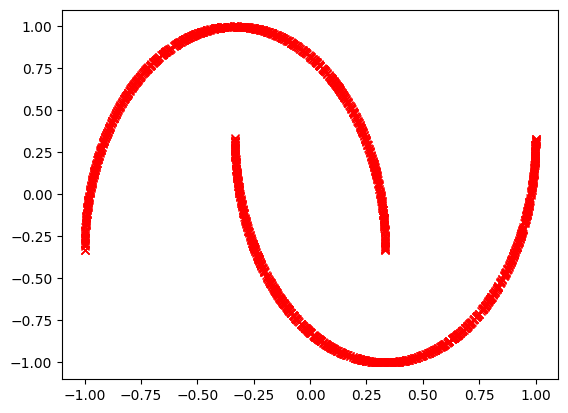

In [5]:
# data
# --------------------------------------------
train_ds, eval_ds = dataset_lib.get_dataset(
    dataset_name,
    train_batch_size=batch_size,
    eval_batch_size=batch_size,
    num_jit_steps=None,
    image_size=None,
    random_flip=None,
    data_category=None,
    uniform_dequantization=False,
    num_two_dim_samples=10_000,
)
train_iter = iter(train_ds)

# set up data transform
transform_fn = lambda x: x
batch = jax.tree_map(lambda x: x._numpy(), next(train_iter))
x = batch['x']
plot_x = x[0]
plt.plot(plot_x[:,0], plot_x[:,1], 'rx')

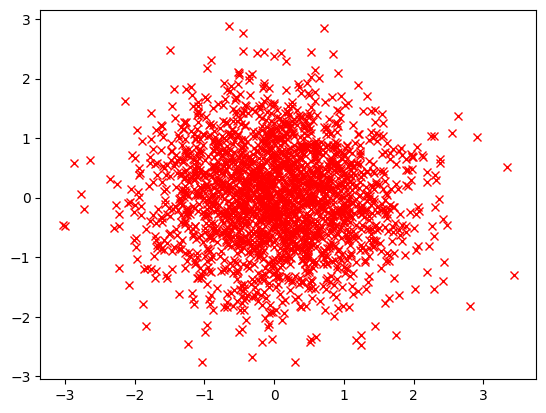

In [12]:
init_t = jnp.zeros((batch_size,))
init_x = x[0]
init_rng = jax.random.PRNGKey(0)

init_state = diffusion_lib.init_diffusion_state(
        x_init=init_x, t_init=init_t, rng=init_rng
    )
t = jnp.ones((batch_size))*T_max
forward_state = state_sampler(init_state, t)
plot_x = forward_state.x_t
plt.plot(plot_x[:,0], plot_x[:,1], 'rx')

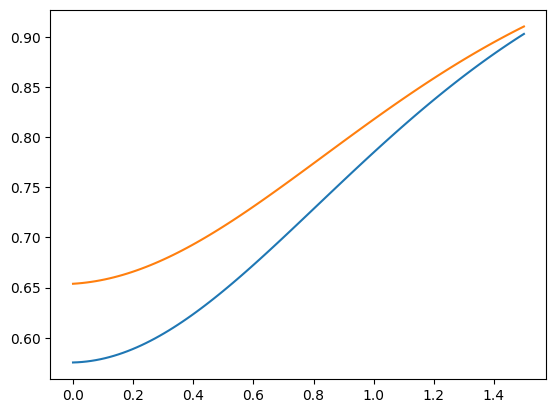

In [13]:
init_t = jnp.zeros((batch_size,))
init_x = x[0]
init_rng = jax.random.PRNGKey(42)

init_state = diffusion_lib.init_diffusion_state(
        x_init=init_x, t_init=init_t, rng=init_rng
    )

mean_ts = []
std_ts = []
ts = []
int_ts = []
for step_t in jnp.linspace(0, T_max, 100):

    t = jnp.ones((batch_size))*step_t
    forward_state = state_sampler(init_state, t)
    mean_t = jnp.mean(forward_state.x_t-mean_T, axis=0)
    std_t = jnp.std(forward_state.x_t, axis=0)
    
    mean_ts.append(np.array(mean_t).copy())
    std_ts.append(std_t)
    ts.append(t[0])
    int_ts.append(beta_schedule.integral_beta_t(t)[0])
    
plt.plot(ts, std_ts)

int_ts = jnp.array(int_ts)
ts = jnp.array(ts)
mean_ts = jnp.array(mean_ts)
std_ts = jnp.array(std_ts)

In [14]:
ts[jnp.where(int_ts[int_ts<2])]

Array([0.01515152, 0.03030303, 0.04545455, 0.06060606, 0.07575758,
       0.09090909, 0.10606061, 0.12121212, 0.13636364, 0.15151516,
       0.16666667, 0.18181819, 0.1969697 , 0.21212122, 0.22727273,
       0.24242425, 0.25757575, 0.27272728, 0.2878788 , 0.3030303 ,
       0.3181818 , 0.33333334, 0.34848487, 0.36363637, 0.37878788,
       0.3939394 , 0.40909094, 0.42424244, 0.43939394, 0.45454547,
       0.469697  , 0.4848485 , 0.5       , 0.5151515 , 0.53030306,
       0.54545456, 0.56060606, 0.5757576 , 0.5909091 , 0.6060606 ,
       0.6212121 , 0.6363636 , 0.6515152 , 0.6666667 , 0.6818182 ,
       0.69696975, 0.71212125, 0.72727275, 0.74242425, 0.75757575,
       0.7727273 , 0.7878788 , 0.8030303 , 0.8181819 , 0.8333334 ,
       0.8484849 , 0.8636364 , 0.8787879 , 0.89393944, 0.90909094,
       0.92424244, 0.939394  , 0.9545455 , 0.969697  , 0.9848485 ,
       1.        , 1.0151515 , 1.030303  , 1.0454546 , 1.0606061 ,
       1.0757576 , 1.0909091 , 1.1060606 , 1.1212121 , 1.13636

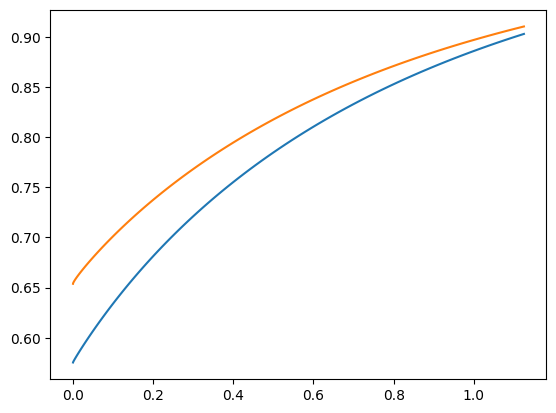

In [15]:
plt.plot(int_ts, std_ts)

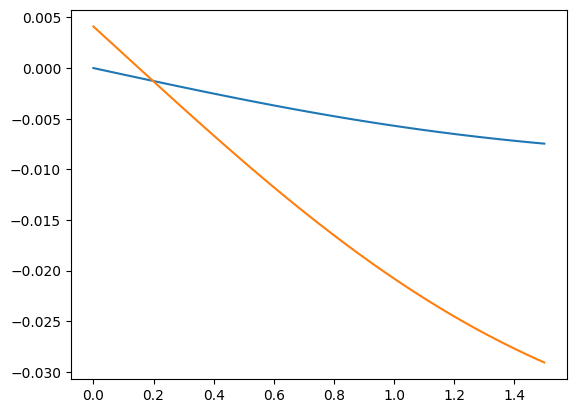

In [16]:
plt.plot(ts, mean_ts)


In [17]:
t = jnp.ones((batch_size))*T_max*10
mean_t, std_t = sampler_lib.compute_ou_moments(mean_T, sigma_T, forward_state.x_0, t)

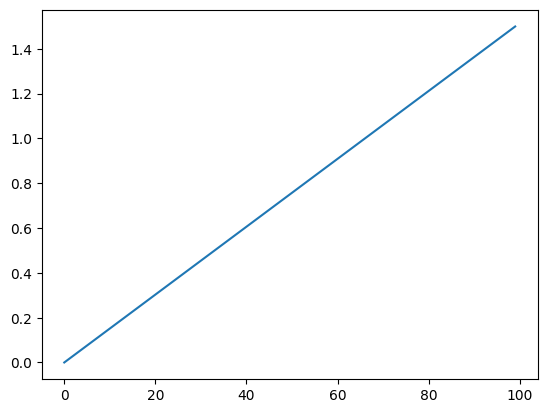

In [19]:
plt.plot(ts)